In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# Initialize a Spark session
spark = SparkSession.builder.appName("HotelBookingCancellation").getOrCreate()

In [3]:
# Load the dataset 
data = spark.read.csv("hotel_bookings.csv", header=True, inferSchema=True)

In [4]:
total_entries = data.count() * len(data.columns)
print("Total Entries in the DataFrame:", total_entries)

Total Entries in the DataFrame: 3820480


In [5]:
from pyspark.sql.types import StringType, IntegerType
# Get the column names and data types
column_data_types = data.dtypes

# Extract column names with StringType
categorical_cols = [col_name for col_name, col_type in column_data_types if col_type == 'string']
# Print or use the list of string column names
print("String Columns:", categorical_cols)
print(" ")
print(" ")
numerical_cols = [col_name for col_name, col_type in column_data_types if col_type == 'int']
print("num Columns:", numerical_cols)

String Columns: ['hotel', 'arrival_date_month', 'children', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type', 'reservation_status']
 
 
num Columns: ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']


In [14]:
import pandas as pd
num_cols=['is_canceled','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights', 'previous_cancellations','previous_bookings_not_canceled']
pandas_data = data.select(num_cols).toPandas()
pandas_data = data.select(numerical_cols).toPandas()

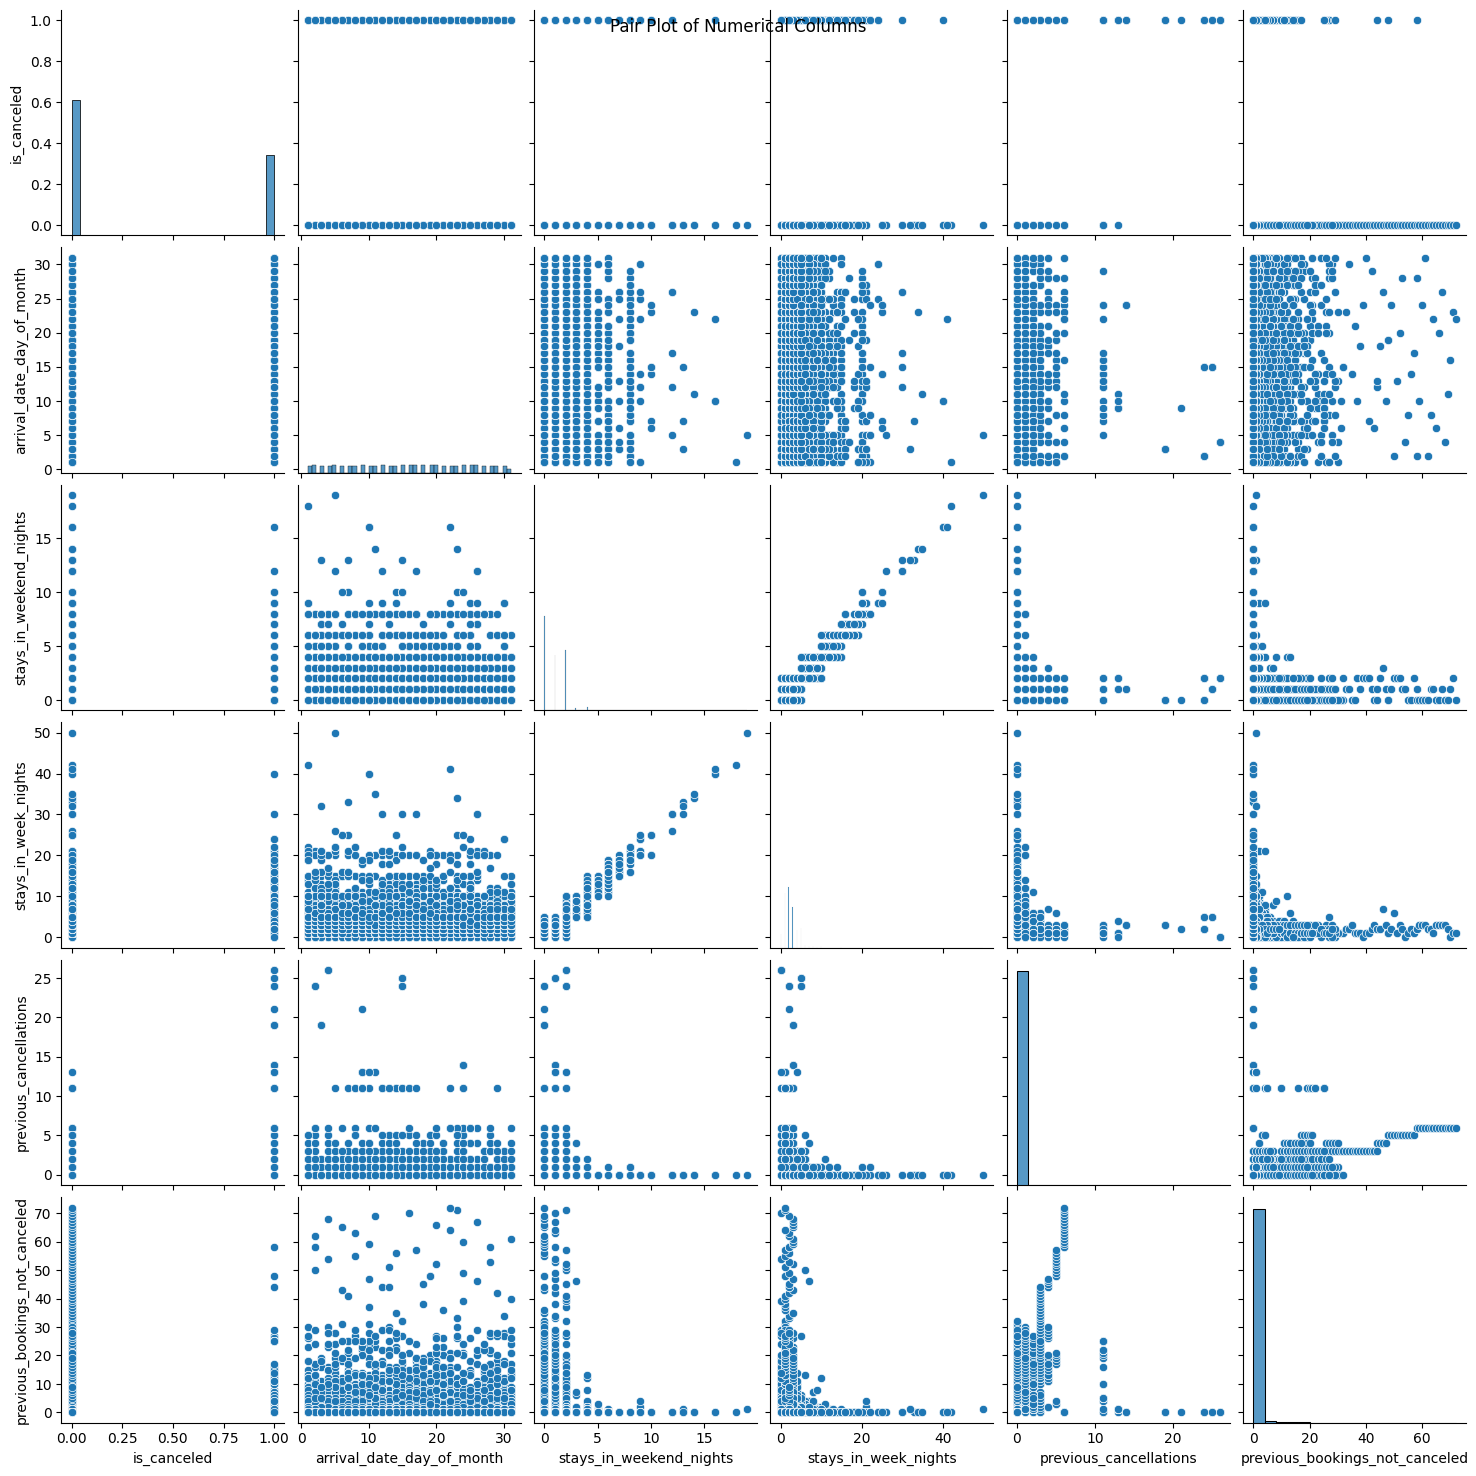

In [9]:
# Pair plot for numerical columns
sns.pairplot(pandas_data)
plt.suptitle("Pair Plot of Numerical Columns")
plt.show()

ValueError: num must be an integer with 1 <= num <= 6, not 7

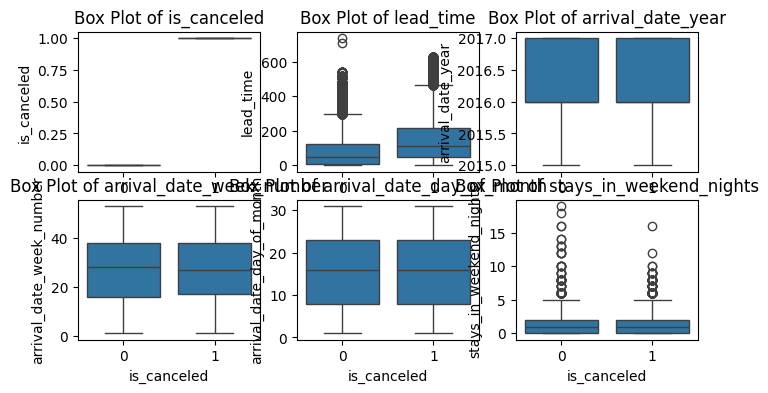

In [15]:
# Box plots for numerical columns
plt.figure(figsize=(8, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='is_canceled', y=col, data=pandas_data)
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [16]:
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep') for col in categorical_cols]
encoder = OneHotEncoder(inputCols=[f"{col}_index" for col in categorical_cols], outputCols=[f"{col}_encoded" for col in categorical_cols])

assembler = VectorAssembler(inputCols=[f"{col}_encoded" for col in categorical_cols] + numerical_cols, outputCol="features")

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="is_canceled", featuresCol="features")

In [18]:
# Define the classifier
classifier = RandomForestClassifier(labelCol="is_canceled", featuresCol="features", seed=42)


In [19]:
# Create the pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler, classifier])
pipeline1 = Pipeline(stages=indexers + [encoder, assembler, dt])

In [20]:
# Split the dataset into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [21]:
# Train the model
model = pipeline.fit(train_data)
# Train the model
model1 = pipeline1.fit(train_data)


In [40]:
# Make predictions on the test set
predictions = model.transform(test_data)
predictions1 = model1.transform(test_data)

In [41]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="is_canceled")
area_under_curve = evaluator.evaluate(predictions)
area_under_curve1= evaluator.evaluate(predictions1)

In [43]:
print(f"Area under ROC curve: {area_under_curve}")
print(f"Area under ROC curve: {area_under_curve1}")

Area under ROC curve: 0.9999999733841523
Area under ROC curve: 1.0


In [44]:
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(labelCol="is_canceled", featuresCol="features") 

In [52]:
pipeline2 = Pipeline(stages=indexers + [encoder, assembler, svm])
model2=pipeline2.fit(train_data)
prediction2=model2.transform(test_data)

In [53]:
area_under_curve2= evaluator.evaluate(prediction2)

In [54]:
print(f"Area under ROC curve: {area_under_curve2}")

Area under ROC curve: 0.9999999239547207


In [78]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedFMeasure")
f1_score = evaluator_f1.evaluate(prediction)
print(f"Weighted F1 Score: {f1_score}")

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedRecall")
recall = evaluator_recall.evaluate(prediction2)
print(f"Weighted Recall: {recall}")

Weighted Recall: 1.0


In [60]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions1)
print(f"Weighted Recall: {recall}")

Weighted Recall: 1.0


In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Weighted Recall: {recall}")

Weighted Recall: 0.9999578361512839


In [59]:
# Evaluate Precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions1)
print(f"Weighted Precision: {precision}")

Weighted Precision: 1.0


In [63]:
# Evaluate Precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(prediction2)
print(f"Weighted Precision: {precision}")

Weighted Precision: 1.0


In [64]:
# Example: Predict cancellation for a new data point
new_data_point = spark.createDataFrame([("City Hotel", "August", "0", "BB", "PRT", "Online TA", "TA/TO", "A", "A",
                                         "No Deposit", "240", "NULL", "Transient", "Check-Out", 0, 120, 2016, 32, 12, 2, 3,
                                         0, 0, 0, 0, 0, 0, 0, 0, 1, 0)],
                                       ["hotel", "arrival_date_month", "children", "meal", "country",
                                        "market_segment", "distribution_channel", "reserved_room_type",
                                        "assigned_room_type", "deposit_type", "agent", "company", "customer_type",
                                        "reservation_status", "is_canceled", "lead_time", "arrival_date_year",
                                        "arrival_date_week_number", "arrival_date_day_of_month",
                                        "stays_in_weekend_nights", "stays_in_week_nights", "adults", "babies",
                                        "is_repeated_guest", "previous_cancellations",
                                        "previous_bookings_not_canceled", "booking_changes", "days_in_waiting_list",
                                        "required_car_parking_spaces", "total_of_special_requests"])


##### Make prediction using the loaded model
prediction = model.transform(new_data_point)
prediction.select("prediction").show()

In [65]:
# Make prediction using the loaded model
prediction = model.transform(new_data_point)
prediction.select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
+----------+



In [74]:
##### Make prediction using the loaded model
predictions1 = model1.transform(new_data_point)
predictions1.select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
+----------+



In [75]:
##### Make prediction using the loaded model
prediction2 = model2.transform(new_data_point)
prediction2.select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
+----------+



In [70]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedFMeasure")
f1_score = evaluator_f1.evaluate(prediction)
print(f"Weighted F1 Score: {f1_score}")

Weighted F1 Score: 1.0


In [76]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedFMeasure")
f1_score = evaluator_f1.evaluate(predictions1)
print(f"Weighted F1 Score: {f1_score}")

Weighted F1 Score: 1.0


In [77]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_canceled", metricName="weightedFMeasure")
f1_score = evaluator_f1.evaluate(prediction2)
print(f"Weighted F1 Score: {f1_score}")

Weighted F1 Score: 1.0
